In [1]:
import mesa_reader as mr
import matplotlib.pyplot as plt
import numpy as np
import mesa_data
import mkipp
%matplotlib inline

In [2]:
# %load mesa_data.py
import numpy as np
import numpy.ma as ma

#class to extract a mesa data file.
class Mesa_Data:
    def __init__(self, history_file, only_read_header = False, read_data = True, read_data_cols = [], clean_data = True):
        self.filename = history_file
        #header is a dictionary with the general info from the second and third line of file
        self.header = {}
        #columns is a dictionary which gives the column number (minus 1) corresponding to the key
        self.columns = {}
        file = open(self.filename, "r")
        #first line is not used
        file.readline()
        #following two lines have header data
        header_names = file.readline().split()
        header_vals = file.readline().split()
        for i, header_name in enumerate(header_names):
            self.header[header_name] = float(header_vals[i])
        if only_read_header:
            file.close()
            return
        #next line is empty
        file.readline()
        #following two lines have column data
        nums = file.readline().split()
        names = file.readline().split()
        for i, name in enumerate(names):
            self.columns[name] = int(nums[i])-1
        file.close()

        if not read_data:
            return

        if len(read_data_cols) == 0:
            read_data_cols = self.columns.keys()
        self.read_data(read_data_cols, clean_data = clean_data)


    def read_data(self, column_names, clean_data = True):
        #always include model_number if its part of the data
        if "model_number" not in column_names and "model_number" in self.columns:
            column_names.append("model_number")

        #read data
        data = np.loadtxt(self.filename, skiprows = 6, \
            usecols = tuple([self.columns[k] for k in column_names]), unpack = True)

        self.data = {}
        #Be careful in case only one column is required
        if len(data.shape) > 1:
            for i, column in enumerate(column_names):
                self.data[column] = data[i]
        else:
            self.data[column_names[0]] = data

        #clean redos
        if clean_data and "model_number" in self.columns and len(self.data["model_number"]) > 1:
            #create a mask
            model_number = self.data["model_number"]
            mask = np.zeros(len(model_number))
            max_model_number = model_number[-1]
            #last entry is valid, start from there and remove repeats
            for i in range(len(model_number)-2,-1,-1):
                if model_number[i] >= max_model_number:
                    mask[i] = 1
                else:
                    max_model_number = model_number[i]

            if sum(mask) > 0:
                for column in column_names:
                    self.data[column] = ma.masked_array(self.data[column], mask=mask).compressed()

    def get(self,key):
        return self.data[key]

#reads the profiles.index files in the folders specified by the logs_dirs array and returns
#an array containing paths to the individual profile files, after cleaning up redos and backups
def get_profile_paths(logs_dirs = ["LOGS"]):
    profile_paths = []
    for log_dir in logs_dirs:
        model_number, paths = np.loadtxt(log_dir+"/profiles.index", skiprows = 1, usecols = (0,2), unpack = True)
        mask = np.zeros(len(paths))
        max_model_number = model_number[-1]
        #last entry is valid, start from there and remove repeats
        for i in range(len(model_number)-2,-1,-1):
            if model_number[i] >= max_model_number:
                mask[i] = 1
            else:
                max_model_number = model_number[i]

        if sum(mask) > 0:
            paths = ma.masked_array(paths, mask=mask).compressed()
        profile_paths.extend([log_dir+"/profile"+str(int(i))+".data" for i in paths])
    return profile_paths

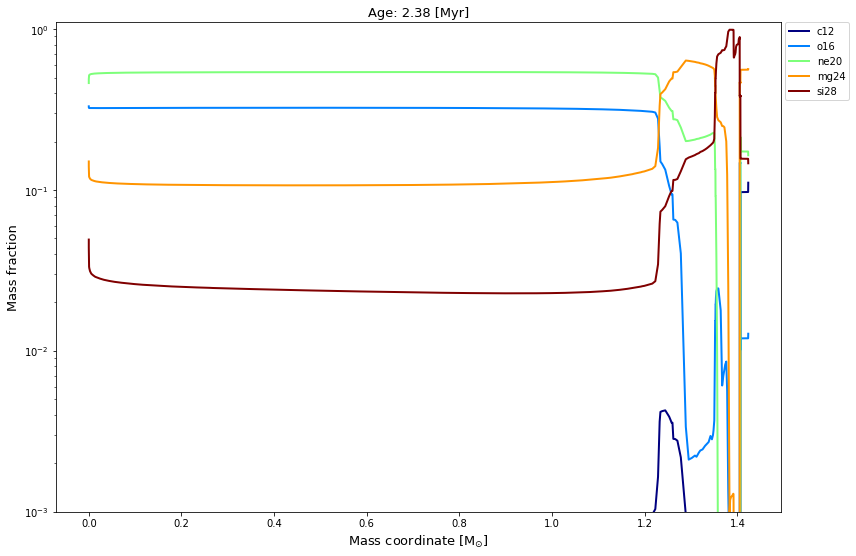

In [5]:
# ABUNDANCE PROFILE FOR A 2.5M HELIUM STAR

def chem_profile(location,profile_number):
    infile = location + 'profile' + str(profile_number) + '.data'
    if 'si28' in Mesa_Data(infile).columns:
        y_variables = ['c12', 'o16', 'ne20', 'mg24', 'si28']
    else:
        y_variables = ['he4', 'c12', 'n14', 'o16', 'ne20', 'mg24']
    data_table = Mesa_Data(infile)
    x = data_table.get('mass')
    abundances = []
    for y in y_variables:
        bla = data_table.get(y)
        abundances.append(bla)
    time = Mesa_Data(infile).header['star_age']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.set_aspect('equal')
    ax.set_xlabel(r'Mass coordinate [M$_{\odot}$]', fontsize = 13)
    ax.set_ylabel('Mass fraction', fontsize = 13)
    lab = 'Age: ' + str(round(time / (10**6), 2)) + " [Myr]"
    fig.set_size_inches([13,9])
    ncolors = 5
    #color=iter(plt.cm.Dark2(np.linspace(0,1,ncolors)))
    color=iter(plt.cm.jet(np.linspace(0,1,ncolors)))
    bla = len(abundances)
    for i in range(0,bla):
        c=next(color)
        ab = y_variables[i]
        image = ax.semilogy(x,abundances[i],label=ab,c=c,linewidth=2)
    #ax.set_xlim(4,10)
    ax.set_ylim(1e-3,1.1)
    ax.set_title(lab, fontsize = 13)
    ax.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
    #ax.legend(loc='best')
    #fig.savefig('../2p5M/final_abundance_profile.png', dpi = 300)
    
    return image

source = '../2p5M/'
im1 = chem_profile(source, 'final')